In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz
import os

In [2]:
train_data = gcv.data.RecordFileDetection('./Deep-Waldo/data/train.rec')
valid_data = gcv.data.RecordFileDetection('./Deep-Waldo/data/valid.rec')
classes = ['Waldo']  # only one foreground class here

idx = np.random.randint(len(train_data))
image, labels = train_data[idx]
print('boxes:', labels)

boxes: [[  198.  1879.   239.  1923.     0.]]


In [3]:
from mxnet.gluon.data import DataLoader
from gluoncv.data.transforms import presets

def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
        train_transform = presets.yolo.YOLO3DefaultTrainTransform(width, height, net)
        train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader


try:
    ctx = [mx.gpu(0)]
    print('gpu is a success')
except:
    ctx = [mx.cpu()]

gpu is a success


## Model

In [4]:
net = gcv.model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
net.reset_class(classes)
# net.collect_params()
# .reset_ctx(ctx)

batch_size = 4
train = get_dataloader(net, train_data, 512, batch_size, 0) # look into modifying this because what is our data sahpe?

trainer = gluon.Trainer(
    net.collect_params(), 'adam',
    {'learning_rate': 0.01, 'wd': 0.0005})

mbox_loss = gcv.loss.YOLOV3Loss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

In [10]:
try:
      net.load_parameters('./model/yolo_waldo.params')
      print('Model Loaded')
except:
      pass

num_epochs = 10

for epoch in range(num_epochs):
  
    ce_metric.reset() 
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
#     net.hybridize(static_alloc=True, static_shape=True) # look this up if you wan tot know more https://mxnet.incubator.apache.org/api/python/gluon/gluon.html?highlight=hybridize#mxnet.gluon.Block.hybridize
    for i, batch in enumerate(train):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        input_order = [0, 6, 1, 2, 3, 4, 5]

        with autograd.record():
            obj_loss, center_loss, scale_loss, cls_loss = net(*[batch[o] for o in input_order])
            
            sum_loss = obj_loss + center_loss + scale_loss + cls_loss

            autograd.backward(sum_loss)
        
        trainer.step(batch_size)
        
        print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, Obs Loss={:.3f}, Center Loss={:.3f}, Scale Loss={:.3f}, Cls Loss={:.3f}'.format(
            epoch, i, batch_size/(time.time()-btic), sum_loss[0].asscalar(), sum_loss[1].asscalar(), sum_loss[2].asscalar(), sum_loss[3].asscalar()))
        
        btic = time.time()
        
    if not os.path.isdir('./model'):
        os.mkdir('./model')
      
    net.save_parameters('./model/yolo_waldo.params')
    
    print('Model Saved at Epoch {0}'.format(epoch))

Model Loaded
[Epoch 0][Batch 0], Speed: 3.343 samples/sec, Obs Loss=32.401, Center Loss=15.829, Scale Loss=12.863, Cls Loss=16.969
[Epoch 0][Batch 1], Speed: 0.424 samples/sec, Obs Loss=40.938, Center Loss=36.689, Scale Loss=23.851, Cls Loss=25.267
[Epoch 0][Batch 2], Speed: 0.514 samples/sec, Obs Loss=20.477, Center Loss=19.378, Scale Loss=40.201, Cls Loss=19.060
[Epoch 0][Batch 3], Speed: 0.514 samples/sec, Obs Loss=15.854, Center Loss=15.144, Scale Loss=17.129, Cls Loss=15.253
[Epoch 0][Batch 4], Speed: 0.512 samples/sec, Obs Loss=17.405, Center Loss=23.597, Scale Loss=55.313, Cls Loss=39.612
[Epoch 0][Batch 5], Speed: 0.582 samples/sec, Obs Loss=65.814, Center Loss=29.034, Scale Loss=30.121, Cls Loss=16.834
[Epoch 0][Batch 6], Speed: 0.534 samples/sec, Obs Loss=20.489, Center Loss=15.537, Scale Loss=32.349, Cls Loss=30.542
Model Saved at Epoch 0
[Epoch 1][Batch 0], Speed: 2.401 samples/sec, Obs Loss=18.644, Center Loss=21.483, Scale Loss=21.786, Cls Loss=34.761
[Epoch 1][Batch 1], 

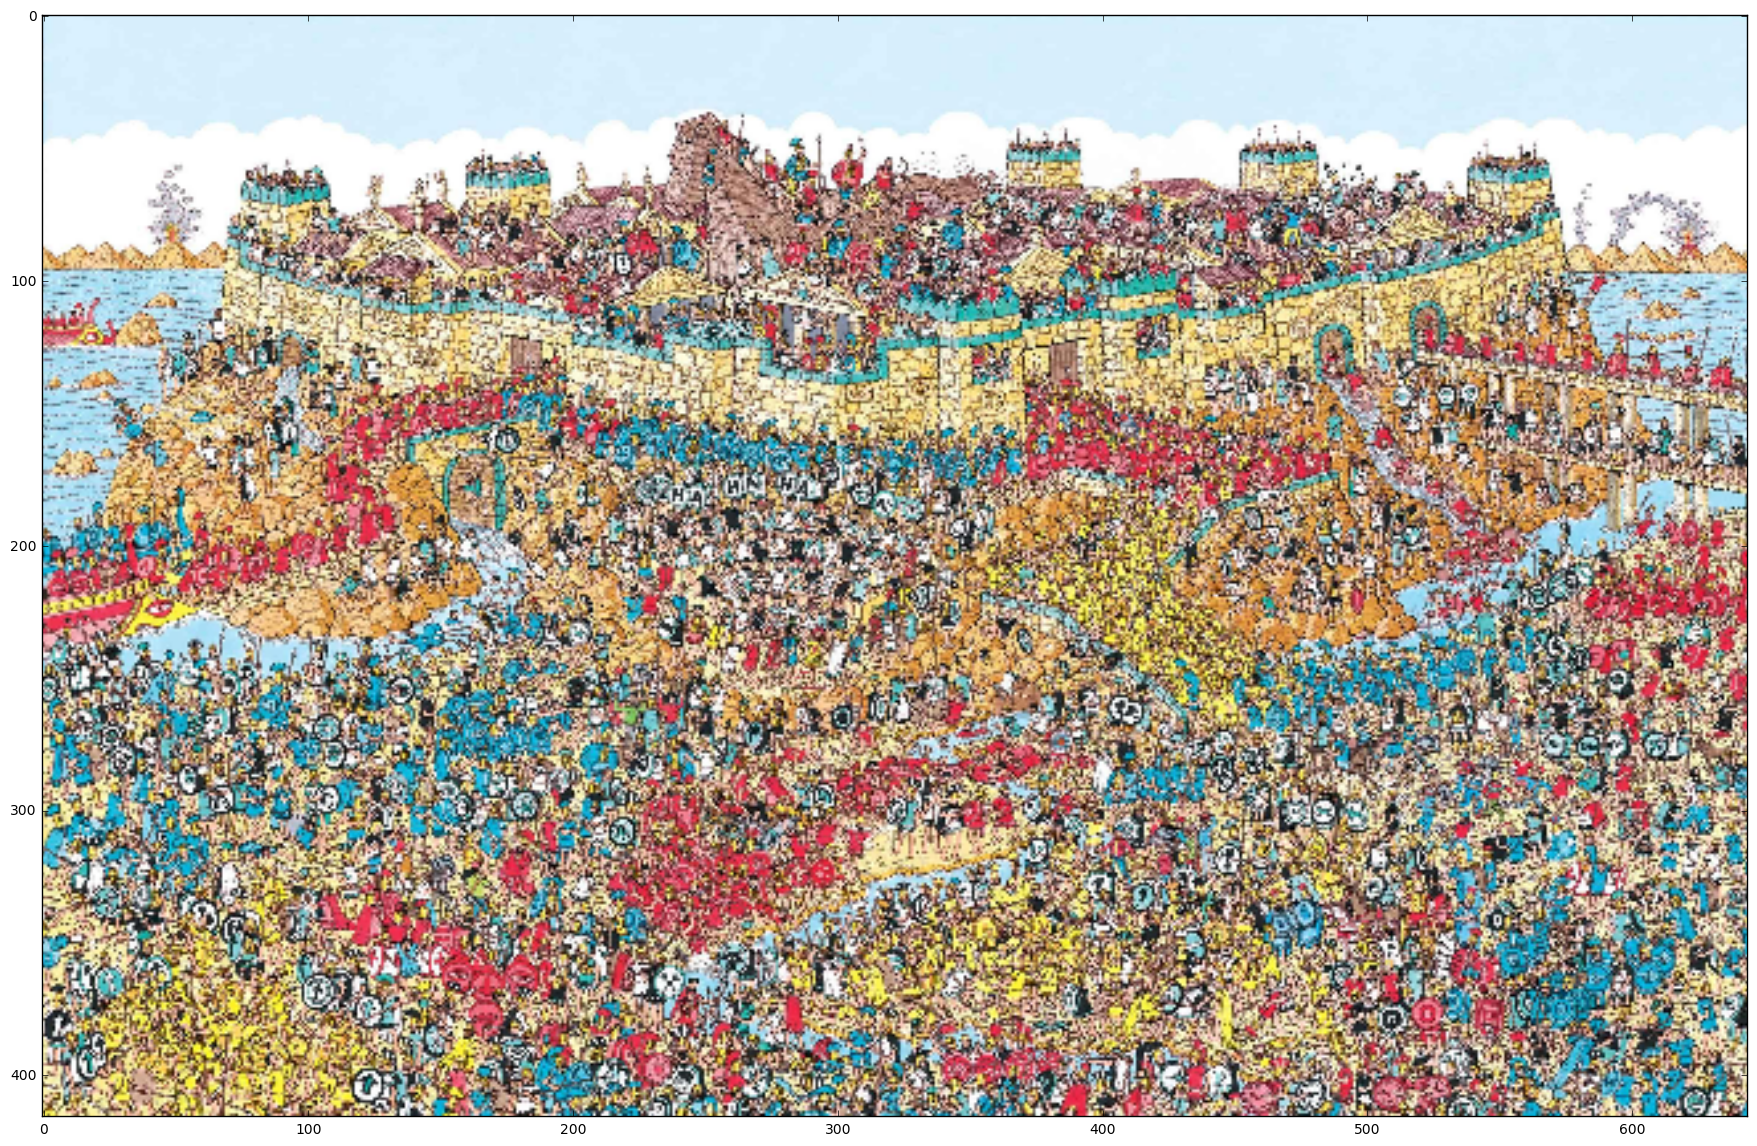

In [6]:
net = gcv.model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)
net.reset_class(classes)
net.load_parameters('./model/yolo_waldo.params')

x, image = gcv.data.transforms.presets.yolo.load_test('./Deep-Waldo/data/original/11.jpg')
cid, score, bbox = net(x)
fig = plt.figure(figsize=(22,20))
ax = fig.add_subplot(1, 1, 1)
# bbox = bbox[:, :4]
# cid = cid[:, 4:5]
# viz.plot_bbox(image, bbox, labels=cid, class_names=classes, ax=ax)
viz.plot_bbox(image, bbox, score, cid, class_names=classes, ax=ax)
plt.show()

In [11]:
net.

SyntaxError: invalid syntax (<ipython-input-11-ced4a4750f30>, line 1)